# Variance-based sensitivty analysis with OpenTURNS

In [1]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, date
import time
import seaborn as sns
plt.style.use("seaborn")

import scipy.stats

import plotly.graph_objects as go
# import plotly.express as px
# https://plotly.com/python/parallel-coordinates-plot/
# https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
# https://plotly.com/python/reference/parcoords/

In [2]:
# openturns libraries

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import pickle
import json

In [3]:
np.sum([40000, 70000, 190000, 290000, 180000, 60000] )

830000

In [4]:
path_simulation_result = 'Studies/Sobol_MC_50000_InfectedDead.pkl'
path_data = 'data/worldometer_data.txt'

In [5]:
# Define Comartment names
compartments = ['susceptible', 'exposed', 'carrier', 'infected', 'hospitalized', 'icu', 'recovered', 'dead']
Compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']

In [6]:
with open(path_simulation_result, 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)
    runtime = pickle.load(f)

In [7]:
print(f"Size of Monte Carlo experiment is {size}.")
print(f"The Monte Carlo experiment needed {runtime} s.")
print(f"{len(input_factor_names)} input factors were used.")
print(f"The model was simulated {len(sim_out)} times.")
print("Static params: ", static_params)
#print(f"Considered input factors are {input_factor_names}")

Size of Monte Carlo experiment is 50000.
The Monte Carlo experiment needed 20584.82719063759 s.
80 input factors were used.
The model was simulated 4100000 times.
Static params:  {'num_groups': 6, 'num_compartments': 8, 'populations': [40000, 70000, 190000, 290000, 180000, 60000], 'start_day': 77, 'days': 100, 'dt': 0.1, 'output_index': [3, 7], 'output_operation': 'all'}


In [51]:
number_of_days = static_params['days']
print(number_of_days)
print(sim_out.shape)

100
(4100000, 101, 2)


In [9]:
# load data
data_dict = {}
with open(path_data) as f:
    lines = f.readlines()
    #data_dict.update(lines[0])
    print(lines[-1])
    for i in range(len(lines)-1):
        (key, value) = lines[i].split(":")
        value = json.loads(value)
        data_dict[key] = value
print(data_dict.keys())

start_dataset = 32
print(data_dict['categories'][start_dataset])

# when used for a different time period, initial numbers must be matched first. 
# Saved simulation is from start day 0, therefore no initial numbers in Hospitalized, Infected and Recovered
# Divide by 100 because of the population size used in the model
dataset = np.zeros((number_of_days+1, len(static_params['output_index'])))
dataset[:, 0] = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0
dataset[:, 1] = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0

source : "https://www.worldometers.info/coronavirus/country/germany/#graph-deaths-daily"

dict_keys(['categories', 'currently_infected', 'total_deaths', 'new_recoveries'])
Mar 18, 2020


In [10]:
def aggregate_output(aggregation_function, output_no, number_of_days = number_of_days):

    if aggregation_function == "max":
        output_agg = np.max(sim_out[:, :number_of_days, output_no], axis = 1, keepdims = True)
    elif aggregation_function == "sum":
        output_agg = np.sum(sim_out[:, :number_of_days, output_no], axis = 1, keepdims=True)
    elif aggregation_function == "mean":
        output_agg = np.mean(sim_out[:, :number_of_days, output_no], axis = 1, keepdims=True)
    elif aggregation_function == "mse":
        output_agg = ((np.array(sim_out[:, :, output_no]) - dataset[:, output_no])**2).mean(axis = 1, keepdims = True)
    #print(f"Aggregated output is {aggregation_function} {output_compartment}.")
    return output_agg

def get_output_name(aggregation_function, output_no):
    out_comp = compartments[static_params['output_index'][output_no]]
    return f"{aggregation_function} {out_comp}"

In [16]:
# create list which contains all outputs of interest
outputs = []
output_names = []
df_outputs = pd.DataFrame()
for agg in ["max", "mse"]:
    for out_id in [0, 1]:
        out_comp = compartments[static_params['output_index'][out_id]]
        print(f"Aggregated output is {agg} {out_comp}.")
        outputs.append(aggregate_output(agg, out_id))
        output_names.append(f"{agg} {out_comp}")
        df_outputs[f"{agg} {out_comp}"] = np.squeeze(aggregate_output(agg, out_id))
print(len(outputs))       
print(output_names)

Aggregated output is max infected.
Aggregated output is max dead.
Aggregated output is mse infected.
Aggregated output is mse dead.
4
['max infected', 'max dead', 'mse infected', 'mse dead']


In [17]:
df_outputs

,max infected,max dead,mse infected,mse dead
0,132712.913066,7093.199877,3.951461e+09,1.017429e+07
1,2085.479331,95.904749,6.073591e+05,5.738132e+02
2,162371.026236,6569.578649,4.545488e+09,9.956037e+06
3,153812.754139,7053.420183,4.519291e+09,1.139168e+07
4,56503.508048,2061.782461,6.732776e+08,4.344524e+05
...,...,...,...,...
4099995,8515.133016,773.053680,2.627013e+07,6.833847e+04
4099996,24811.186922,188.489031,4.566796e+07,9.845731e+02
4099997,127891.175959,6117.971175,4.108530e+09,4.596181e+06
4099998,38464.292088,1312.090862,3.368754e+08,1.812099e+05


# Simulation dataframe

Contains input factor values and 4 different outputs from each experiment.

In [51]:
size

50000

In [49]:
# use subset (with size 'n_outputs') for visualization if experiment is very large
n_outputs = 100
randidx = np.sort(np.random.randint(0, 2*size, n_outputs))

df = inputDesign[randidx].asDataFrame()
i = 0
for agg in ["max", "mse"]:
    for out_id in [0, 1]:
        out_comp = compartments[static_params['output_index'][out_id]]
        df[f"{agg} {out_comp}"] = outputs[i][randidx, 0]
        i += 1
# serial interval is modelled as a factor of incubation time. show the product here to ease interpretablity
#df['serial_interval'] = df['serial_interval']*df['incubation_time']
df.head()

,dummy,incubation_time,serial_interval,infectious_mild_time,hospitalized_to_ICU_time,risk_of_infection_from_symptomatic,max_risk_of_infection_from_symptomatic,seasonality,test_and_trace_capacity,NPI_strength_home,...,deaths_per_ICU_3,deaths_per_ICU_4,deaths_per_ICU_5,init_exposed,init_carrier,init_infected,max infected,max dead,mse infected,mse dead
0,0.276178,5.552617,0.665852,7.574362,6.919545,0.179703,0.326767,0.154091,0.845745,0.603211,...,0.143601,0.433941,0.558381,4.536023,24.554852,125.803083,112921.937070,3373.907606,2.680437e+09,1.189051e+06
1,0.276015,5.463812,0.712016,5.770349,5.462405,0.192864,0.343708,0.168802,1.157589,0.298030,...,0.120025,0.359117,0.597157,107.086713,80.592195,127.484741,53745.396954,1784.425636,7.630846e+08,2.903902e+05
2,0.968402,4.726867,0.804631,7.149763,5.510566,0.177970,0.388367,0.158387,0.979823,0.324846,...,0.106985,0.426563,0.559139,177.530003,160.647871,127.633094,91742.878388,4049.874674,2.012807e+09,2.410552e+06
3,0.743592,6.737464,0.841474,7.420116,3.725421,0.257724,0.400860,0.234838,1.070607,0.078712,...,0.175025,0.354608,0.696285,79.260336,109.017624,122.366015,3625.841384,64.219357,1.264428e+06,2.039978e+03
4,0.711276,4.277032,0.817166,7.548427,4.238956,0.106952,0.306224,0.268202,0.878380,0.363563,...,0.100296,0.432262,0.622797,135.213876,198.615208,126.759207,550.383204,58.352049,8.951073e+03,1.072605e+03


# Compute sensitivity indices

In [18]:
df_first = pd.DataFrame()
df_total = pd.DataFrame()

for i in range(len(outputs)):    
    print(f"Compute variance based sensitivity for output: {output_names[i]}.")

    output_agg = outputs[i]
    outputDesign = ot.Sample(output_agg)
    sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

    df_first[output_names[i]] = np.array(sensitivityAnalysis.getFirstOrderIndices())
    df_total[output_names[i]] = np.array(sensitivityAnalysis.getTotalOrderIndices())

Compute variance based sensitivity for output: max infected.
Compute variance based sensitivity for output: max dead.
Compute variance based sensitivity for output: mse infected.
Compute variance based sensitivity for output: mse dead.


In [19]:
df_first.index = input_factor_names
df_total.index = input_factor_names
df_first.sort_values(by = ['max dead'], ascending = False).style.format("{:.6f}")

,max infected,max dead,mse infected,mse dead
serial_interval,0.299436,0.285933,0.252309,0.198132
relative_carrier_infectability_2,0.071999,0.051792,0.059983,0.030986
relative_carrier_infectability_3,0.055488,0.042601,0.045779,0.033781
NPI_start_day_other,0.018828,0.014125,0.014967,0.004147
NPI_start_day_home,0.014960,0.011374,0.012004,0.000114
NPI_start_day_school,0.015869,0.010877,0.011932,-0.003430
NPI_start_day_work,0.017188,0.010840,0.014180,-0.001439
infectious_mild_time,0.016794,0.003955,0.032697,0.002357
NPI_strength_school,0.019040,0.002877,0.013771,-0.010869
NPI_strength_home,0.019046,0.002565,0.013285,-0.014970


In [27]:
df_rankings = pd.DataFrame()
for order in ['first', 'total']:
    for i in (output_names):
        if order == 'total':
            df_rankings[f"Ranking: {order}-order of {i}"] = df_total.sort_values(by = [i], ascending = False).index
        else:

            df_rankings[f"Ranking: {order}-order of {i}"] = df_first.sort_values(by = [i], ascending = False).index
df_rankings

,Ranking: first-order of max infected,Ranking: first-order of max dead,Ranking: first-order of mse infected,Ranking: first-order of mse dead,Ranking: total-order of max infected,Ranking: total-order of max dead,Ranking: total-order of mse infected,Ranking: total-order of mse dead
0,serial_interval,serial_interval,serial_interval,serial_interval,serial_interval,serial_interval,serial_interval,serial_interval
1,relative_carrier_infectability_2,relative_carrier_infectability_2,relative_carrier_infectability_2,relative_carrier_infectability_3,NPI_start_day_school,NPI_start_day_school,NPI_start_day_work,relative_carrier_infectability_2
2,relative_carrier_infectability_3,relative_carrier_infectability_3,relative_carrier_infectability_3,relative_carrier_infectability_2,NPI_start_day_other,NPI_start_day_work,NPI_start_day_other,relative_carrier_infectability_3
3,NPI_strength_other,NPI_start_day_other,infectious_mild_time,NPI_start_day_other,NPI_start_day_work,NPI_start_day_other,NPI_start_day_school,NPI_start_day_school
4,NPI_strength_home,NPI_start_day_home,NPI_start_day_other,infectious_mild_time,NPI_start_day_home,NPI_start_day_home,NPI_start_day_home,NPI_start_day_other
...,...,...,...,...,...,...,...,...
75,hospitalized_cases_per_infectious_5,ICU_to_home_time_2,hospitalized_cases_per_infectious_5,ICU_cases_per_hospitalized_3,ICU_to_home_time_1,ICU_cases_per_hospitalized_0,ICU_to_home_time_1,hospitalized_cases_per_infectious_0
76,infection_probability_from_contact_5,asymptotic_cases_per_infectious_1,hospitalized_cases_per_infectious_4,home_to_hospitalized_time_5,ICU_cases_per_hospitalized_1,ICU_to_death_time_0,ICU_cases_per_hospitalized_1,ICU_to_home_time_0
77,asymptotic_cases_per_infectious_2,asymptotic_cases_per_infectious_2,asymptotic_cases_per_infectious_1,asymptotic_cases_per_infectious_5,ICU_to_death_time_1,ICU_to_home_time_0,ICU_to_death_time_0,hospitalized_to_home_time_0
78,asymptotic_cases_per_infectious_1,asymptotic_cases_per_infectious_5,home_to_hospitalized_time_4,deaths_per_ICU_5,deaths_per_ICU_1,hospitalized_to_home_time_0,ICU_to_death_time_1,home_to_hospitalized_time_0


In [62]:
print(df_rankings.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &    Ranking: first-order of max infected &        Ranking: first-order of max dead &    Ranking: first-order of mse infected &        Ranking: first-order of mse dead &    Ranking: total-order of max infected &        Ranking: total-order of max dead &    Ranking: total-order of mse infected &        Ranking: total-order of mse dead \\
\midrule
0  &                         serial\_interval &                         serial\_interval &                         serial\_interval &                         serial\_interval &                         serial\_interval &                         serial\_interval &                         serial\_interval &                         serial\_interval \\
1  &        relative\_carrier\_infectability\_2 &        relative\_carrier\_infectability\_2 &        relative\_carrier\_infectability\_2 &        relative\_carrier\_infectability\_3 &                    NPI\_start\_day\_school &                    NPI\_start\_da

/tmp/ipykernel_2226551/1365450392.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [28]:
from matplotlib.colors import LogNorm

In [33]:
plt.rcParams["axes.grid"] = False

# adjusting: https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
def show_heatmap_of_indices(df, title_str,log = True):
    s_max = np.max(df.iloc[:, :].values)

    selected_ids = [np.arange(0, 25), np.arange(25, 50), np.arange(50, 75)]
    m = 3
    fig, axs = plt.subplots(1,3, figsize = (12, 6))
    for i in range(m):
        if log:
            im = axs[i].imshow((df.iloc[:, :].values[selected_ids[i]]), cmap = 'viridis',norm=LogNorm())
            title = f"Visualization of {title_str}-order sensitivity indices for different outputs (log-scale)"
            saving = f"latex_plots/Sobol_heatmap_{title_str}_order_log.png"
        else:
            im = axs[i].imshow((df.iloc[:, :].values[selected_ids[i]]), cmap = 'viridis', vmin = 0, vmax = s_max) 
            title = f"Visualization of {title_str}-order sensitivity indices for different outputs"
            saving = f"latex_plots/Sobol_heatmap_{title_str}_order_log.png"

        axs[i].set_yticks(np.arange(len(selected_ids[i])))
        axs[i].set_xticks(np.arange(len(df.columns)))

        axs[i].set_yticklabels([input_factor_names[j] for j in selected_ids[i]])
        axs[i].set_xticklabels(df.columns)

        plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.subplots_adjust(top = 0.90)
    fig.suptitle(title, fontsize=16)

    cax = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
    plt.colorbar(im, cax=cax, ) # Similar to fig.colorbar(im, cax = cax)
    plt.savefig(saving)
    plt.show()

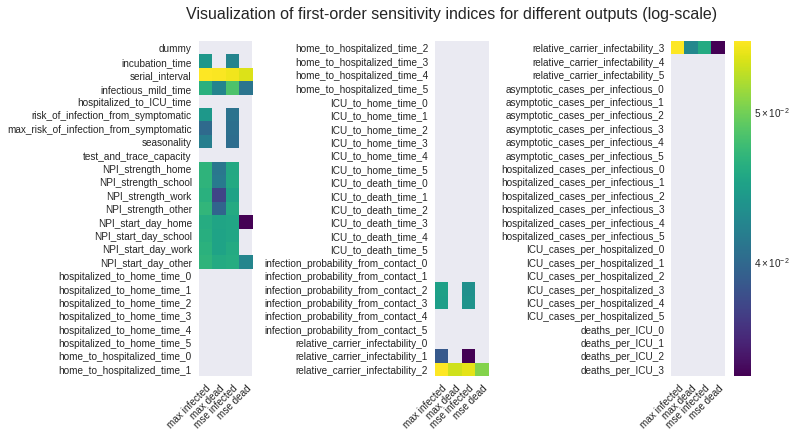

In [38]:
show_heatmap_of_indices(df_first, title_str = 'first', log= True)

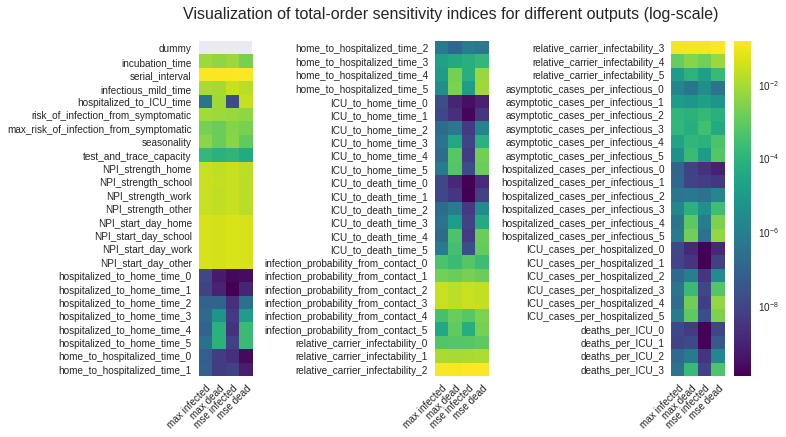

In [39]:
show_heatmap_of_indices(df_total, title_str = 'total', log=True)

In [40]:
print(sensitivityAnalysis.getConfidenceLevel())

0.95


In [96]:
output_agg = outputs[0]
outputDesign = ot.Sample(output_agg)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)


first_order = sensitivityAnalysis.getFirstOrderIndices()
total_order = sensitivityAnalysis.getTotalOrderIndices()

total = np.array(total_order)
first = np.array(first_order)
print(first[0], total[0])

0.006868358385268819 0.0


In [41]:
plt.rcParams["axes.grid"] = True
def show_sensitivity_indices(output_agg, aggregation_function, eps = 1e-2, sort_by = 'main'):
    outputDesign = ot.Sample(output_agg)
    sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)
    #agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
    #agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
    first_order = sensitivityAnalysis.getFirstOrderIndices()
    total_order = sensitivityAnalysis.getTotalOrderIndices()
    first = np.array(first_order)
    total = np.array(total_order)
    firstCI = sensitivityAnalysis.getFirstOrderIndicesInterval()
    totalCI = sensitivityAnalysis.getTotalOrderIndicesInterval()
    
    sorted_ids = list(map(int, np.argsort(total)))
    n = len(input_factor_names)
    title = f"Sensitivity indices of output: {aggregation_function} (sorted by {sort_by} effect)"
    figsize = (10, 40)
    
    if eps > 0:
        figsize = (10, 20)
        relevant_ids = [i for i, t in enumerate(total) if t > eps]
        # sort indices by first or total effect
        if sort_by == 'main':
            sorted_ids = list(map(int, np.argsort(first)))
        else: 
            sorted_ids = list(map(int, np.argsort(total)))
        sorted_ids = np.array(sorted_ids)
        # only take relevant
        sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]
        title = f"""Main and total sensitivity indices of output: {aggregation_function}\n 
                Shown {len(sorted_ids)} of {n} input factors have total effect > {eps} (sorted by {sort_by} effect)"""
    alp = 0.7
    lw = 2
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    inputArray = np.array(inputDesign)
    x = np.arange(0, 1.1, 0.2)
    y = np.arange(0, len(sorted_ids), 1)
    space = 0.4
    y2 = np.arange(0+space, len(sorted_ids)+space, 1)
    axes.scatter(first[sorted_ids], y, label = "First order indices", c = 'red')
    plt.hlines(y=0, xmin=0, xmax=0, 
                   colors='red', linestyles='-', lw=lw, label = "95% CI of first order indices", alpha = alp)
    axes.scatter(total[sorted_ids], y2, label = "Total order indices", c = 'blue')
    plt.hlines(y=0, xmin=0, xmax=0, 
                   colors='blue', linestyles='-', lw=lw, label = "95% CI of total order indices", alpha = alp)
    for i, j in enumerate(sorted_ids):
        plt.hlines(y=y[i], xmin=firstCI.getMarginal(j).getLowerBound()[0], 
                   xmax=firstCI.getMarginal(j).getUpperBound()[0], 
                   colors='red', linestyles='-', lw=lw, alpha = alp)
        plt.hlines(y=y2[i], xmin=totalCI.getMarginal(j).getLowerBound()[0], 
                   xmax=totalCI.getMarginal(j).getUpperBound()[0], 
                   colors='blue', linestyles='-', lw=lw, alpha = alp)
        plt.annotate(str(np.round(first[sorted_ids[i]], 3)), (first[sorted_ids[i]], y[i]+ 0.25*space), ha='center')
        plt.annotate(str(np.round(total[sorted_ids[i]], 3)), (total[sorted_ids[i]], y2[i]+ 0.25*space), ha='center')

    #axes.set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
    axes.set_xticks(x)
    axes.set_yticks(y)
    axes.set_yticklabels([input_factor_names[k] for k in sorted_ids], fontsize = 14)
    plt.legend(loc='upper right')
    plt.ylim([-0.2, len(sorted_ids)])
    plt.xlim([-0.2, 1.2])
    plt.title(title, fontsize = 18)
    plt.tight_layout()
    plt.show()

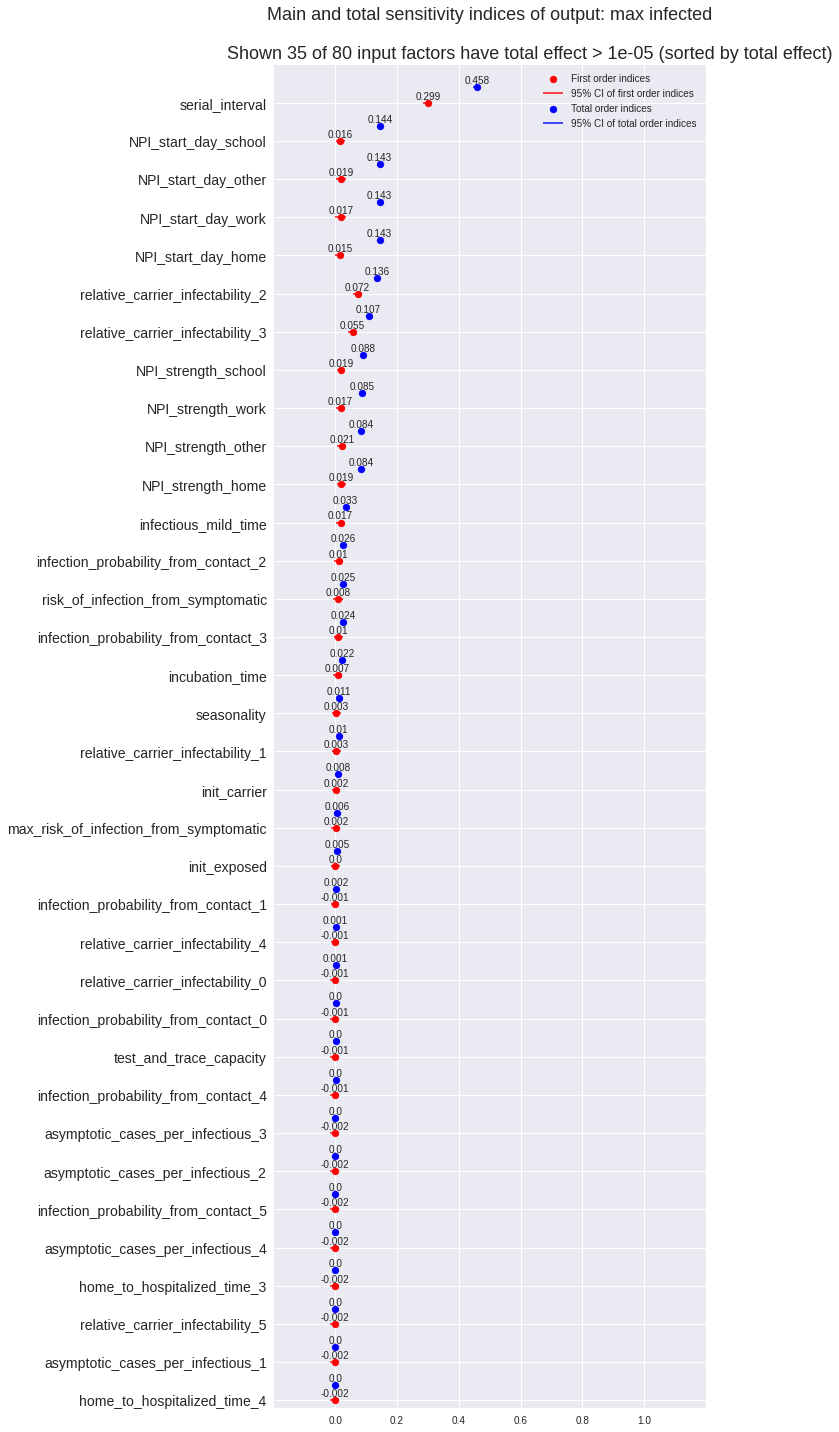

In [42]:
show_sensitivity_indices(output_agg = outputs[0], aggregation_function=output_names[0], eps = 1e-5, sort_by = 'total')

## Visualize most sensitive indices

In [204]:
# take only factors with total effect larger epsilon
eps = 1e-2
relevant_ids = [i for i, t in enumerate(total) if t > eps]

# sort indices by main effect
sorted_ids = list(map(int, np.argsort(first)))
sorted_ids = np.array(sorted_ids)

# only take relevant
relevant_sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]

relevant_idx = list(reversed(relevant_sorted_ids)) #[i for i, o in enumerate(total) if o > eps]
print(relevant_sorted_ids)
print(relevant_idx)
relevant_columns = [list(df.columns)[i] for i in relevant_idx]
relevant_columns

[9, 5, 2, 39, 40, 1, 8, 6, 7, 12, 10, 11, 3, 0]
[0, 3, 11, 10, 12, 7, 6, 8, 1, 40, 39, 2, 5, 9]


['serial_interval',
 'risk_of_infection_from_symptomatic',
 'damping_time_work',
 'damping_time_school',
 'damping_time_other',
 'damping_coeff_work',
 'damping_coeff_school',
 'damping_coeff_other',
 'infectious_mild_time',
 'infection_probability_from_contact_3',
 'infection_probability_from_contact_2',
 'hospitalized_to_ICU_time',
 'damping_coeff_home',
 'damping_time_home']

In [57]:
def show_cobweb(df, output_agg, aggregation_function, eps = 1e-2, show_above = True, sort_by = 'main'):
    ### prepare data
    outputDesign = ot.Sample(output_agg)
    sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)
    
    first_order = sensitivityAnalysis.getFirstOrderIndices()
    total_order = sensitivityAnalysis.getTotalOrderIndices()
    first = np.array(first_order)
    total = np.array(total_order)
    firstCI = sensitivityAnalysis.getFirstOrderIndicesInterval()
    totalCI = sensitivityAnalysis.getTotalOrderIndicesInterval()
    
    if show_above:
        relevant_ids = [i for i, t in enumerate(total) if t > eps]
        sign = '>'
    else: 
        relevant_ids = [i for i, t in enumerate(total) if t < eps]
        sign = '<'
    # sort indices by main effect
    if sort_by == 'main':
            sorted_ids = list(map(int, np.argsort(first)))
    else: 
        sorted_ids = list(map(int, np.argsort(total)))
    sorted_ids = np.array(sorted_ids)
    # only take relevant
    relevant_sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]
    relevant_sorted_ids = list(reversed(relevant_sorted_ids)) #[i for i, o in enumerate(total) if o > eps]
    relevant_columns = [list(df.columns)[i] for i in relevant_sorted_ids]
    print(relevant_columns)
    
    ### prepare plot
    dims = []
    for i,  rx in enumerate(relevant_sorted_ids):
        dims.append(dict(range = [distributions[rx].getRange().getLowerBound()[0], distributions[rx].getRange().getUpperBound()[0]], 
                        label = relevant_columns[i],
                        values = df[relevant_columns[i]]))
    dims.append(dict(
        range = [0, df[aggregation_function].max()], 
        label = f"output {aggregation_function}", values = df[aggregation_function]))
    #dims[2].update(constraintrange = [6, 7.0])
    #dims[0].update(constraintrange = [3.935, 4.2])
    #dims[-1].update(constraintrange = [10000, 14000])
    color_categories = [[0, 'purple'], [0.25, 'lightseagreen'], [0.75, 'gold'], [1., 'white']]
    ### plot 
    fig = go.Figure(data =
                       go.Parcoords(
                       line = dict(color = df[aggregation_function],
                                  colorscale = color_categories, #continous: 'Electric', 
                                  showscale = True, 
                                  cmin = 0,
                                  cmax = df[aggregation_function].max(),
                                  ),
                       dimensions = dims,
                       labelangle = 45,
                       ),
                   layout = go.Layout(margin = go.layout.Margin(t = 220))
                   )
    fig.update_layout(title=go.layout.Title(
                        text=f"Cobweb visualization of most important inputs for {aggregation_function}" \
                        f" (T_i {sign} {eps}).<br>Sorted by {sort_by} effect",
                        y=0.95
                        ),
                     )
        #title = f"Cobweb visualization of most important inputs (T_i > {eps}). ")
    fig.show()

In [60]:
show_cobweb(df = df, output_agg = outputs[0], aggregation_function = output_names[0], eps = 1e-3, sort_by = 'total')

['serial_interval', 'NPI_start_day_school', 'NPI_start_day_other', 'NPI_start_day_work', 'NPI_start_day_home', 'relative_carrier_infectability_2', 'relative_carrier_infectability_3', 'NPI_strength_school', 'NPI_strength_work', 'NPI_strength_other', 'NPI_strength_home', 'infectious_mild_time', 'infection_probability_from_contact_2', 'risk_of_infection_from_symptomatic', 'infection_probability_from_contact_3', 'incubation_time', 'seasonality', 'relative_carrier_infectability_1', 'init_carrier', 'max_risk_of_infection_from_symptomatic', 'init_exposed', 'infection_probability_from_contact_1', 'relative_carrier_infectability_4']


In [59]:
show_cobweb(df = df, output_agg = outputs[0], aggregation_function = output_names[0], eps = 1e-7, show_above = False, sort_by = 'total')

['hospitalized_to_home_time_0', 'ICU_to_home_time_0', 'hospitalized_to_home_time_1', 'deaths_per_ICU_0', 'ICU_cases_per_hospitalized_0', 'ICU_to_death_time_0', 'ICU_to_home_time_1', 'ICU_cases_per_hospitalized_1', 'ICU_to_death_time_1', 'deaths_per_ICU_1', 'dummy']


In [58]:
show_cobweb(df = df, output_agg = outputs[1], aggregation_function = output_names[1], eps = 1e-3, sort_by = 'total')

['serial_interval', 'NPI_start_day_school', 'NPI_start_day_work', 'NPI_start_day_other', 'NPI_start_day_home', 'relative_carrier_infectability_2', 'relative_carrier_infectability_3', 'NPI_strength_school', 'NPI_strength_work', 'NPI_strength_home', 'NPI_strength_other', 'infectious_mild_time', 'hospitalized_to_ICU_time', 'risk_of_infection_from_symptomatic', 'infection_probability_from_contact_2', 'infection_probability_from_contact_3', 'incubation_time', 'init_carrier', 'relative_carrier_infectability_1', 'init_exposed', 'deaths_per_ICU_4', 'seasonality', 'max_risk_of_infection_from_symptomatic', 'deaths_per_ICU_5', 'relative_carrier_infectability_4', 'home_to_hospitalized_time_5', 'home_to_hospitalized_time_4', 'hospitalized_cases_per_infectious_5', 'ICU_cases_per_hospitalized_4', 'infection_probability_from_contact_1', 'infection_probability_from_contact_4']
